<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Чтение-файла" data-toc-modified-id="Чтение-файла-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Чтение файла</a></span></li><li><span><a href="#Продобработка" data-toc-modified-id="Продобработка-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Продобработка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Обучение</a></span></li></ul></div>

# Прогноз BTC/USD


**Описание проекта**

С платформы Kaggle взяты исторические данные BTC/USD за 2021 год. В рамках проекта стоит задача исследования и разработки модели ML для получения данных о объеме свечи на следующий час. 

**Метрика качества модели** 
- R2

**План выполнения проекта**

0. Изучение предметной области
1. Чтение и предвратиельное изучение файла
2. Предобработка данных 
3. Анализ данных
4. Обучение и тестирование модели
5. Итоги

**Описание данных**

- Unix Timestamp - временная метка Unix - «Время эпохи». Используется для преобразования в местный часовой пояс.
- Date – эта временная метка – часовой пояс UTC.
- Symbol — символ, к которому относятся данные таймсерии.
- Open – это цена открытия за период времени.
- High – это самая высокая цена за период времени.
- Low – это самая низкая цена за период времени.
- Close – это цена закрытия периода времени.
- Volume BTC — это объем проведенных транзакций. Т.е. Для BTC/USDT это сумма в BTC.
- Volume USD —  Для BTC/USDT это сумма в долларах США.

## Чтение файла

In [1]:
import warnings

import numpy as np
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose

import seaborn as sns
import matplotlib.pyplot as plt

import phik

from sklearn.model_selection import (train_test_split, 
                                     cross_val_score, 
                                     TimeSeriesSplit)

from sklearn.linear_model import Ridge, LinearRegression



from sklearn.metrics import make_scorer, r2_score

from sklearn.preprocessing import StandardScaler


In [2]:
data = pd.read_csv('/Users/user/Desktop/DATA/BTC/BTC-2021min.csv', parse_dates=True, index_col=['date'])

Сразу преобразуем тип данных и установим индексы

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 610782 entries, 2022-03-01 03:43:00 to 2021-01-01 00:01:00
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   unix        610782 non-null  int64  
 1   symbol      610782 non-null  object 
 2   open        610782 non-null  float64
 3   high        610782 non-null  float64
 4   low         610782 non-null  float64
 5   close       610782 non-null  float64
 6   Volume BTC  610782 non-null  float64
 7   Volume USD  610782 non-null  float64
dtypes: float64(6), int64(1), object(1)
memory usage: 41.9+ MB


In [4]:
data.head()

,unix,symbol,open,high,low,close,Volume BTC,Volume USD
date,,,,,,,,
2022-03-01 03:43:00,1646106180,BTC/USD,43046.58,43046.58,43046.58,43046.58,0.000000,0.000000
2022-03-01 03:41:00,1646106060,BTC/USD,43018.23,43046.59,43018.23,43046.58,0.142977,6154.673021
2022-03-01 03:40:00,1646106000,BTC/USD,43022.24,43022.24,43016.03,43016.03,0.009230,397.037957
2022-03-01 03:39:00,1646105940,BTC/USD,43035.16,43035.16,42999.44,42999.44,0.820950,35300.390268
2022-03-01 03:38:00,1646105880,BTC/USD,43077.82,43077.82,43049.46,43049.46,0.022210,956.143143


**ВЫВОД 1**

В процессе загрузки CSV преобразовали столбец date в тип данных datetime64 и установлен индекс таблицы равный столбцу date.

В распоряжении 610782 строк кода за период 2022-03-01 03:43:00 до 2021-01-01 00:01:00.



##  Продобработка

На втором этапе необходимо выполнить следующие шаги:

- Обработать порядок данных
- Удалить лишние признаки
- Проверить временную последовательность распределения
- Исследовать корреляцию признаков
- Сгенерировать целевой и доп признаки

In [5]:
# Обработаем порядок данных
data = data.iloc[::-1]

In [6]:
# Дропаем признаки
data = data.drop(['unix', 'symbol'], axis=1)

In [7]:
# Проверим временную последовательность 
data.index.is_monotonic

True

interval columns not set, guessing: ['open', 'high', 'low', 'close', 'Volume BTC', 'Volume USD']


<function matplotlib.pyplot.show(close=None, block=None)>

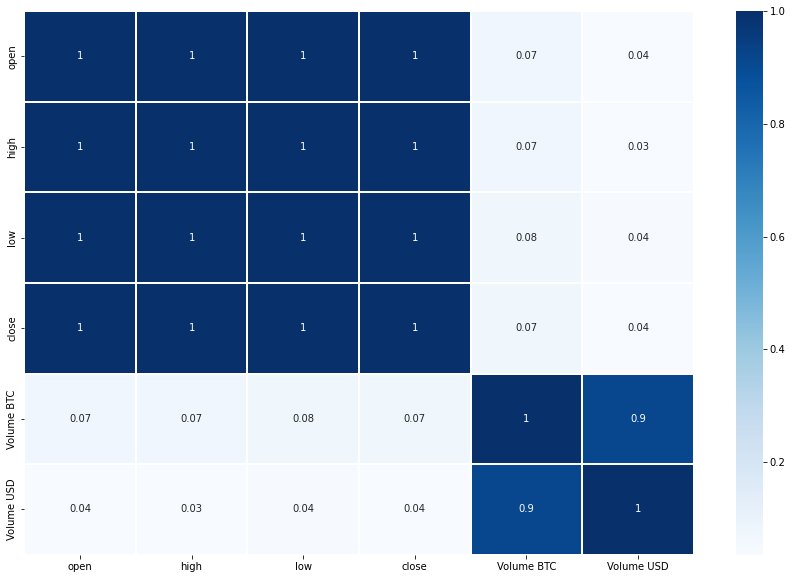

In [8]:
# Строим матрицу корреляции

plt.figure(figsize = (15, 10))
sns.heatmap(data.phik_matrix(), annot = True, 
            fmt='.1g', linewidths=2, cmap='Blues')
plt.show

Видна сильная корреляция между признаками:
- 'open', 
- 'high', 
- 'low',
- 'close'

На их основе сгенерируем новые признаки и после дропнем

In [9]:
data['average'] = data[['open', 'high', 'low', 'close']].mean(axis = 1)
# Тени
#data['upper shadow'] = data['high'] - np.maximum(data['open'], data['close'])
#data['lower shadow'] = np.minimum(data['open'], data['close']) - data['low']

# Тело свечи
data['spread'] = data['high'] - data['low']
data['trade'] = data['close'] - data['open']

In [10]:
# Дропаем признаки
data = data.drop(['high', 'open', 'low', 'close'], axis=1)

In [11]:
data.head(3)

,Volume BTC,Volume USD,average,spread,trade
date,,,,,
2021-01-01 00:01:00,14.561951,423512.060397,29046.2475,79.59,76.16
2021-01-01 00:02:00,3.030301,87987.499279,29051.7125,44.88,-33.91
2021-01-01 00:03:00,2.189621,63604.382387,29043.5500,50.39,10.45


interval columns not set, guessing: ['Volume BTC', 'Volume USD', 'average', 'spread', 'trade']


<function matplotlib.pyplot.show(close=None, block=None)>

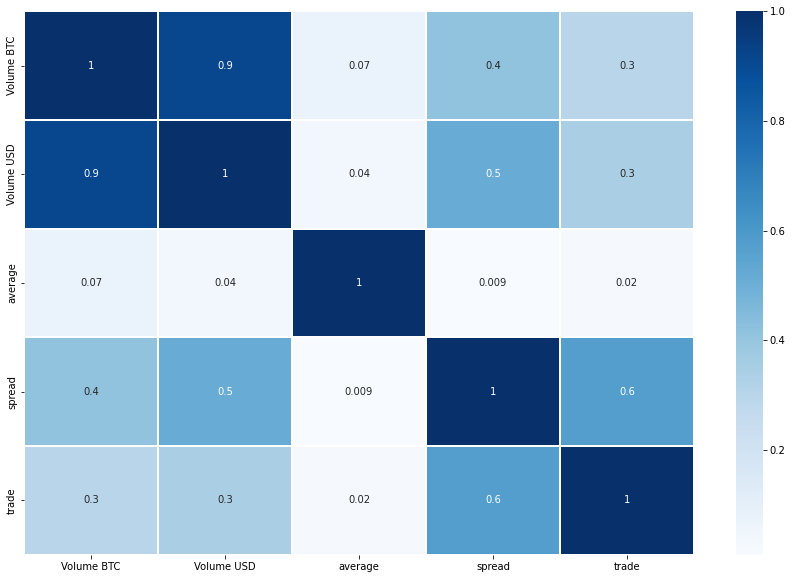

In [12]:
# Строим матрицу корреляции

plt.figure(figsize = (15, 10))
sns.heatmap(data.phik_matrix(), annot = True, 
            fmt='.1g', linewidths=2, cmap='Blues')
plt.show

С выборкой разобрались, теперь посмотрим на распределение BTC/USD

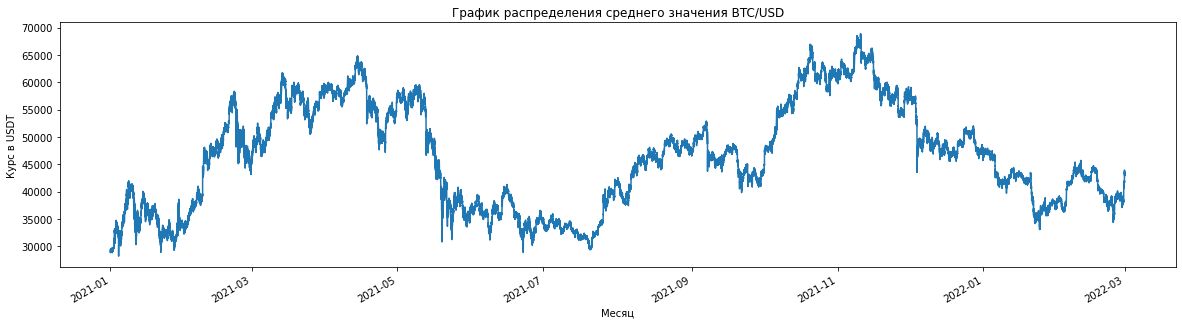

In [13]:
data['average'].plot(subplots=True, figsize=(20, 5))

plt.title('График распределения среднего значения BTC/USD')
plt.xlabel('Месяц')
plt.ylabel('Курс в USDT')

plt.show()

Объем BTC/USD показывает рост с февралая и августа 2021 года. С середины мая график показывает разварот рынка и три месяца вплоть до августа прослеживается медвежий рынок. Макимум за 2021 достигается в ноябре. 

**ВЫВОД 2**

На этапе предобработки были достигнуты все намеченные шаги: 

    - обработан порядок данных
    - сгенерированы новые признаки
    - отсечены ненужные признаки
    - изучена корреляция между данными 

## Анализ

На 3 этапе нужно выполнить следующие шаги:

    - Сделать ресемплирование 
    - Построить график сезонности 
    - Изучить стандартное отклонение по скользящему окну

In [14]:
# Ресемплирование по одному часу
data = data.resample('1H').sum()

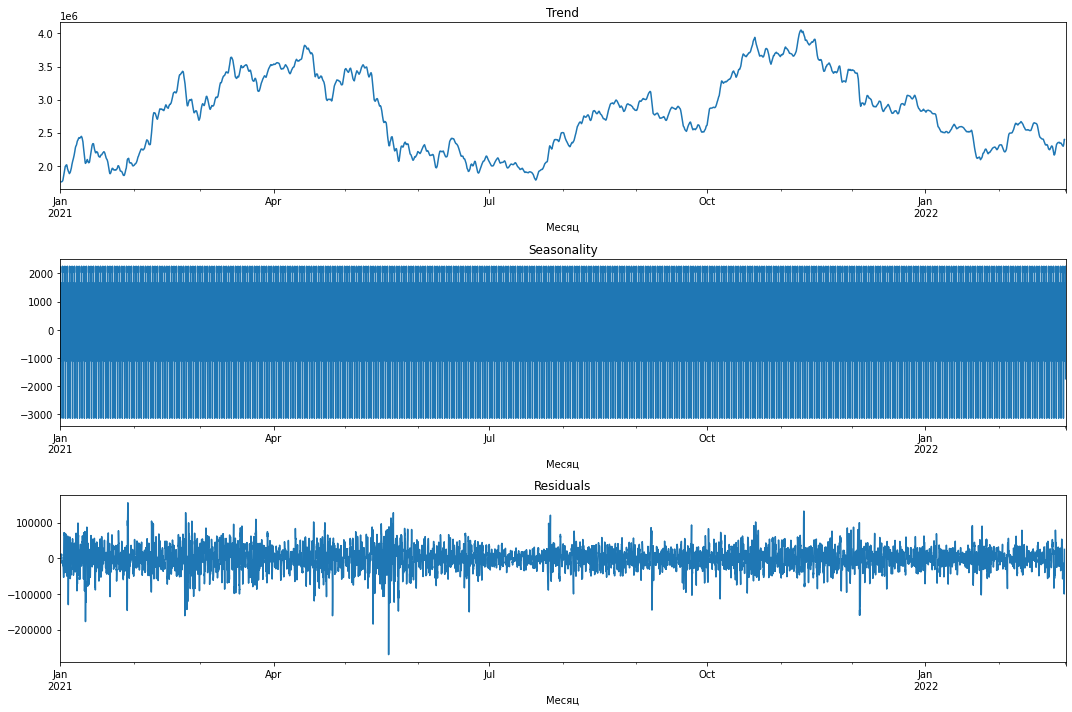

In [15]:
# График сезонности
decomposed = seasonal_decompose(data['average'])

plt.figure(figsize=(15, 10))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.xlabel('Месяц')
plt.subplot(312)

decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.xlabel('Месяц')
plt.subplot(313)

decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.xlabel('Месяц')
plt.tight_layout()

Так как тренды и сезонность зависят от масштаба данных. Нельзя увидеть закономерности, повторяющиеся за каждый период времени, если есть данные только за год.

График сезонности в данном масштабе малоинформативен, сделаем срез данных за неделю/день и посмотрим на результат:

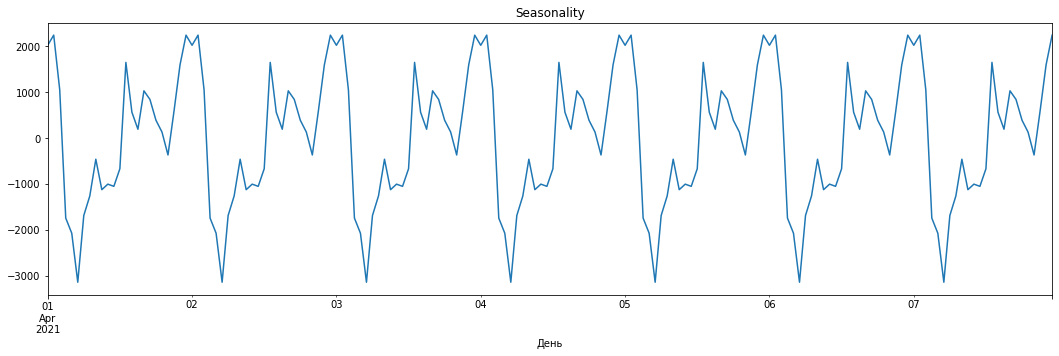

In [16]:
# График сезонности

plt.figure(figsize=(18, 5))
decomposed.seasonal['2021-04-01':'2021-04-07'].plot(ax=plt.gca())
plt.title('Seasonality')
plt.xlabel('День')

plt.show()

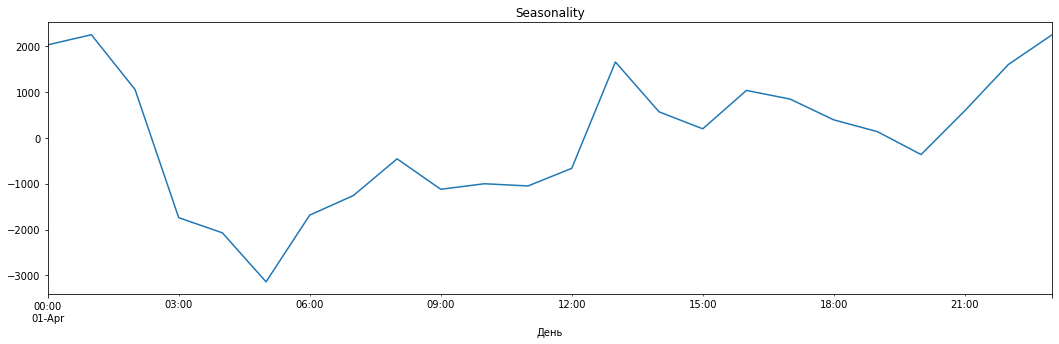

In [17]:
plt.figure(figsize=(18, 5))
decomposed.seasonal['2021-04-01'].plot(ax=plt.gca())
plt.title('Seasonality')
plt.xlabel('День')

plt.show()

График сезонности показывает спад с 01:00 до 05:00 часов и рост на протяжении всего дня.

Построим график показывающий стандартное отклонение по скользящему окну:

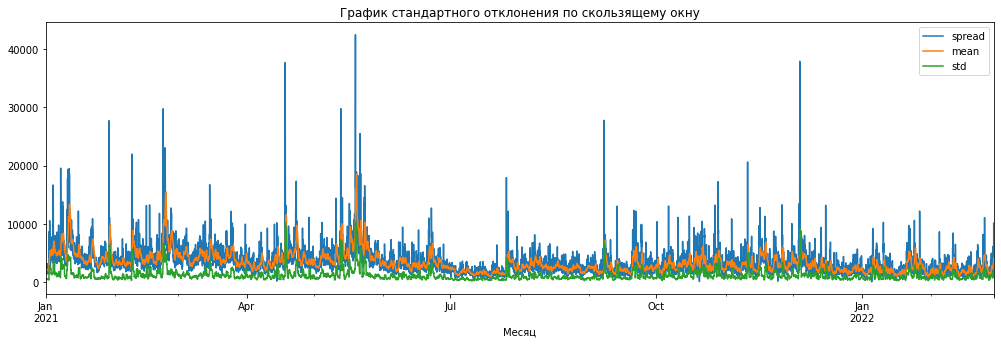

In [18]:
df = data.copy()
df = df.drop(['Volume BTC', 'Volume USD', 'average', 'trade'], axis=1)

df['mean'] = data['spread'].rolling(15).mean()
df['std'] = data['spread'].rolling(15).std()

df.plot(figsize=(17, 5))

plt.title('График стандартного отклонения по скользящему окну')
plt.xlabel('Месяц')
plt.show()

Построим график распределения разностей времянного ряда

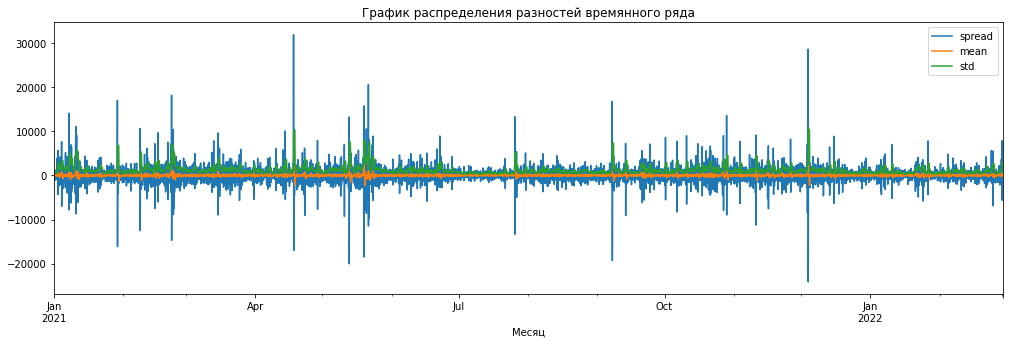

In [19]:
df = df - df.shift()

df['mean'] = df['spread'].rolling(15).mean()
df['std'] = df['spread'].rolling(15).std()

df.plot(figsize=(17, 5))

plt.title('График распределения разностей времянного ряда')
plt.xlabel('Месяц')
plt.show()

**ВЫВОД 3**

Шаги выполнены в соответствии с намеченным планом: ресемплирование по часу и графики:
- сезонности
- стандартного отклонения 
- разностей времянного ряда


## Обучение

Напишем функцию make_features(), чтобы прибавить к таблице новые признаки: день, день недели, час, размер отставания, скользящее среднее

In [20]:
def make_features(df, max_lag, rolling_mean_size):
    
    df_new = df.copy()
    
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    df['hour'] = df.index.hour
    
    #максимальный размер отставания
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['spread'].shift(lag)
        
    #скользящее среднее    
    df['rolling_mean'] = df['spread'].shift().rolling(rolling_mean_size).mean()
    
    return df_new

In [21]:
make_features(data, 8, 2)

data.head(2)

,Volume BTC,Volume USD,average,spread,trade,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,rolling_mean
date,,,,,,,,,,,,,,,,,
2021-01-01 00:00:00,397.103196,1.150240e+07,1708908.955,2320.79,170.87,1,4,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-01 01:00:00,648.597652,1.905370e+07,1761408.045,2866.41,404.57,1,4,1,2320.79,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
data = data.dropna()
data.isna().sum()

Volume BTC      0
Volume USD      0
average         0
spread          0
trade           0
day             0
dayofweek       0
hour            0
lag_1           0
lag_2           0
lag_3           0
lag_4           0
lag_5           0
lag_6           0
lag_7           0
lag_8           0
rolling_mean    0
dtype: int64

In [23]:
data.head(2)

,Volume BTC,Volume USD,average,spread,trade,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,rolling_mean
date,,,,,,,,,,,,,,,,,
2021-01-01 08:00:00,305.297627,8.887783e+06,1746351.510,2283.39,-117.19,1,4,8,2098.24,1485.98,1479.82,1972.10,1832.16,2367.73,2866.41,2320.79,1792.110
2021-01-01 09:00:00,306.830396,8.982544e+06,1755442.355,1708.67,147.93,1,4,9,2283.39,2098.24,1485.98,1479.82,1972.10,1832.16,2367.73,2866.41,2190.815


In [24]:
features_train, features_test, target_train, target_test = train_test_split(
    data.drop('spread', axis=1), data['spread'], test_size=0.3, shuffle=False)

print('Тренировочная выборка:', features_train.shape)
print('Тестовая выборка:', features_test.shape)
print()
print('Целевой признак тренировочная выборки:', target_train.shape)
print('Целевой признак тестовой выборки:', target_test.shape)

Тренировочная выборка: (7120, 16)
Тестовая выборка: (3052, 16)

Целевой признак тренировочная выборки: (7120,)
Целевой признак тестовой выборки: (3052,)


С помощью StandardScaler() стандартизируем данные

In [25]:
# Создадим объект этой структуры
# И настроим его на обучающих данных
scaler = StandardScaler()
scaler.fit(features_train)

# Сохраним проеобразование для тренировочный выборки 
features_train = scaler.transform(features_train)

# Сохраним проеобразование для тестовой выборки
features_test = scaler.transform(features_test)

In [26]:
# Подготовим скорер
r2 = make_scorer(r2_score, greater_is_better=True)

In [27]:
# Количество разделений n_splits=5
time_cv = TimeSeriesSplit(n_splits=5)

**LinearRegression()**

In [28]:
%%time

model_lr = LinearRegression()
model_lr.fit(features_train, target_train)

scores = cross_val_score(model_lr, 
                         features_train, 
                         target_train,
                         scoring=r2,
                         cv=time_cv) 

final_score = pd.Series(scores).mean()

print('----------------')
print("R2:{:.4f}".format(final_score))
print('----------------')

----------------
R2:0.7056
----------------
CPU times: user 2.47 s, sys: 54.6 ms, total: 2.52 s
Wall time: 2.38 s


**Ridge()**

In [29]:
%%time

model = Ridge(random_state=1234, max_iter=111, solver='auto')
model.fit(features_train, target_train)

scores = cross_val_score(model, 
                         features_train, 
                         target_train,
                         scoring=r2,
                         cv=time_cv)

final_score = pd.Series(scores).mean()

print('----------------')
print("R2:{:.4f}".format(final_score))
print('----------------')

----------------
R2:0.7055
----------------
CPU times: user 146 ms, sys: 34.9 ms, total: 181 ms
Wall time: 29.7 ms


**Тестирование**

In [30]:
predict = model_lr.predict(features_test)

print("Коэффициент детерминации:", r2_score(target_test, predict))

Коэффициент детерминации: 0.7275408195132276


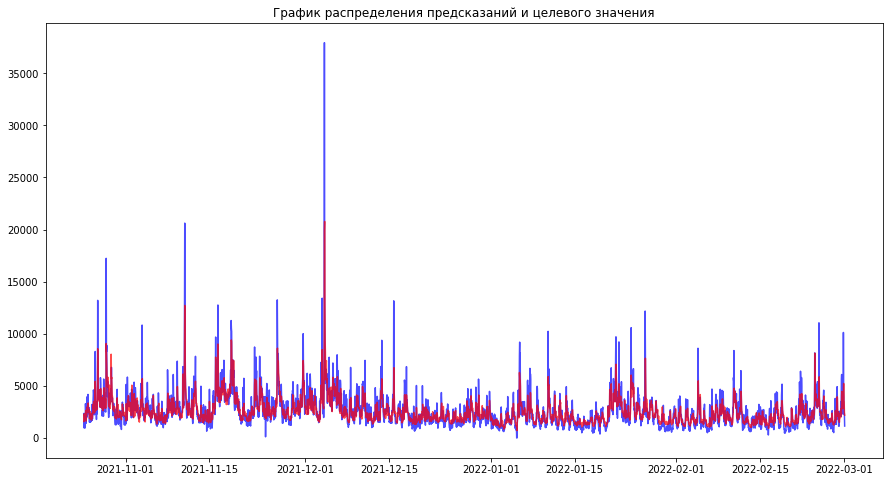

In [31]:
plt.figure(figsize=(15, 8))
plt.plot(target_test.index, target_test, 'b-', 
         target_test.index, predict, 'r-', alpha=0.7)

plt.title('График распределения предсказаний и целевого значения')
plt.show()

**ОБЩИЙ ВЫВОД:**

В рамках проекта обучена модель регресси для прогназа обьема BTC/USD:

- Лучшая модель - LinearRegression()
- R2 на тесте - 0.727